In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Static Variables

In [2]:
line = "46A"

### Reading Data

In [3]:
df = pd.read_csv("bus_data/line_data/" + line + ".csv", low_memory=False, header=None)
df.columns = ["Timestamp", "LineID", "JourneyPatternID", "TimeFrame", 
              "VehicleJourneyID", "Lon", "Lat", "VehicleID", "StopID", 
              "AtStop", "HumanTime", "Day", "Hour", "Runtime"]

#convert StopID to string

df['StopID'] = df['StopID'].astype('str')


df.shape

(312253, 14)

### Getting Stop Locations

In [4]:
# # Isolating variations - getting variation with most stops

patterns = df['JourneyPatternID'].unique()

for pattern in patterns:
    print(pattern)

1
1001
1003
8
1006
1004
1005
5
4
3
1002
2


In [5]:
# Concat location data

df['location'] = ""
df['location'] = df['Lon'].astype(str) + "_" + df['Lat'].astype(str)

stop_loc = {}


In [6]:
# Getting biggest pattern

max_pattern = df['JourneyPatternID'].value_counts().idxmax()
new_df = df[df.JourneyPatternID == max_pattern]

In [7]:
# cutting stops that don't appear more than 20 times

groups = new_df.groupby('StopID')
new_df = groups.filter(lambda x: len(x) > 20)

In [8]:
groups = new_df.groupby('StopID')

In [9]:
# Extracting the most frequent locations for each stop
loc_df = groups['location'].agg(lambda x:x.value_counts().index[0]).to_frame()
loc_df.reset_index(level=0, inplace=True)

# Converting location back to float columns
loc_df['Lon'], loc_df['Lat'] = loc_df['location'].str.split('_', 1).str
loc_df['Lon'], loc_df['Lat'] = loc_df['Lon'].astype('float64'), loc_df['Lat'].astype('float64')

# drop concatenated colum 'location'
loc_df = loc_df.drop('location', axis=1)

### Cleaned location data vs raw location data

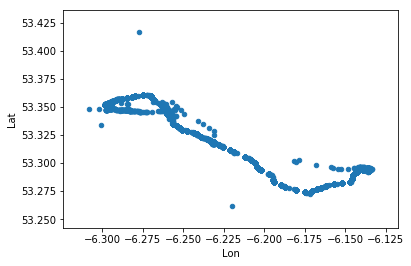

In [10]:
# Raw

locations = new_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

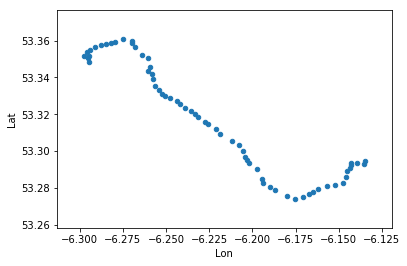

In [11]:
# Clean

locations = loc_df[["Lon", "Lat"]]
locations.plot.scatter(x="Lon", y="Lat")

### Getting Stop Orders

In [12]:
runtimes = new_df.groupby("StopID").Runtime.mean()

order = runtimes.sort_values().to_frame()
order.reset_index(level=0, inplace=True)
order['Order'] = order.index

### Merging dataframes and saving results

In [13]:
static_stops = pd.merge(order, loc_df, on='StopID')
static_stops

,StopID,Runtime,Order,Lon,Lat
0,2039,117.862915,0,-6.134798,53.294781
1,334,263.214286,1,-6.294900,53.348331
2,2040,361.865286,2,-6.135499,53.292816
3,2041,496.072150,3,-6.139282,53.293621
4,2042,625.937975,4,-6.142717,53.293655
5,2043,643.574268,5,-6.142740,53.292503
6,2044,679.807611,6,-6.143744,53.290894
7,2045,699.286245,7,-6.145074,53.289112
8,2046,755.545692,8,-6.145655,53.286030
9,4568,836.624244,9,-6.147297,53.282879


In [14]:
static_stops.to_csv('bus_data/static_data/routestops' + line + '.csv')